In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import thinkstats2
import thinkplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, root_mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Assignment 4 - Classification

For this assignment, you'll need to perform a classification on a dataset, as well as do some prep work on the data. 

The exact steps of what you need to do are flexible and up to you to some degree, however you should consider some of the important things we've mentioned recently, such as:
<ul>
<li> Is the target balanced?
<li> Are there missing or erroneous values?
<li> Are there categorical or numerical features?
<li> Is there colinearity?
<li> Are there outliers?
<li> Should we normalize? 
<li> Do the distributions of the features give any indication that some may need work? 
</ul>

Basically, the data is in the original, potentially dirty, format, and you need to find what should be cleaned, and do the cleaning. There is not one "right" answer to what has to be done, and you'll probably need to do it with at least something of an iterative process - find an issue, correct it, check the data, repeat.

<b>The target that we are predicting is the loan_status. </b>

## Grading

The grades will be broken down as follows:
<ul>
<li> <b>30%</b> - a working predictive model with a reasonable level of accuracy. 
    <ul>
    <li> For the accuracy part, it will not be explicitly graded, but compared to all the others. If you're in the same general range, that's good - if yours is drastically less accurate (or, I guess more accurate), then I'll adjust. There won't be a comparison of "this person is 72.3% and this person is only 71.8% accurate, they fail."
    <li> This data is larger than most of the small sample sets, so random variations due to train-test splits shouldn't be too bad. (If you're a keener you could loop)
    <li> I will use the F1 score as the accuracy metric. 
    </ul>
<li> <b>40%</b> - a clear and readable description of what steps you took to prepare the data, and a brief not on the rationale behind it. Did you do a log transformation to a skewed feature, did you remove outliers, did you remove a feature that has a lot of missing values? Please put this somewhere obvious and readable, consider the goal of the assignment to explain your process to me. 
    <ul>
    <li> E.g. "The target data was imbalanced, so I tried several resampling methods and chose the one with the highest accuracy of the resulting model", "the feature X had the same value for 95% of records, so I dropped it". 
    <li> In this, please also state if you see a group that appears to be a good credit risk, and a group that is a bad credit risk, and indicate the evidence showing that. Please do this other than the most simplistic way - more money = better credit. If there are no such groups, state why you think this. This will likely be about 3 - 5 statements or points, you should provide evidence from the data, but it does not need to be an essay. (You may want to consider this question after you're pretty much done with the data prep and modelling.)
    </ul>
<li> <b>30%</b> - allowing your model to be "deployed". At the bottom of this file there is a small block of code to load in some test data (that I have), and calculate your accuracy. Your contribution to this part is to have a model that is ready to make predictions. Some specifics to consider:
    <ul>
    <li> The test data will be in exactly the same format as the dataset you're given. So any steps that you took to prepare your data for modelling will need to be mirroed here, so the new  data can be predicted. The easiest way to do this is to use a pipeline, but it is up to you. Remember the model only accepts data that is in a certain format - the one that you had the data in when it was trained, so when making predictions you need to make sure that is true. 
    <li> Since I'm providing test data, and your task is to just create a model, think about how that might impact your train-test splitting, both as you're developing and for the final product. 
    <li> Once the model is trained it should predict any data that is in the right format, so I should be able to provide any proper dataset, click run on that testing cell, and get predictions. I will not be doing anything that will purposefully make this harder or trickier, like including data that has errors or is in the wrong format, I just split the entire set of data, reserved part of it to test accuracy, and gave the rest to you. Things that you've changed (e.g. dropping a column, one-hot encoding) do need to be replicated at some point before the model can accept the new data to predict. In general we <b>do</b> want to check in our processing that our input is valid, this is kind of a junior introduction to that. 
    </ul>
</ul

## Data Preparation

In [ ]:
df = pd.read_csv("test copy.csv")
df.head()

,Unnamed: 0,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,16028,23,100000,MORTGAGE,7.0,EDUCATION,A,15000,7.88,0,0.15,N,4
1,19349,33,14400,RENT,2.0,MEDICAL,B,3000,11.83,1,0.21,N,5
2,31084,46,62047,RENT,4.0,MEDICAL,A,10000,9.63,1,0.14,N,13
3,29998,40,43000,MORTGAGE,18.0,MEDICAL,C,2500,12.84,0,0.06,N,14
4,24071,27,38000,RENT,0.0,VENTURE,B,10000,9.76,0,0.26,N,5


In [127]:
# Impute Missing Values with the Median
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].median())
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())

In [128]:
# Drop irrelevant/redundant columns
df = df.drop(columns=['Unnamed: 0', 'loan_grade'])

In [151]:
# --- Load and Clean Raw Data (Only imputation for this plot) ---
df_raw = pd.read_csv('test copy.csv')
df_raw['person_emp_length'] = df_raw['person_emp_length'].fillna(df_raw['person_emp_length'].median())
df_raw['loan_int_rate'] = df_raw['loan_int_rate'].fillna(df_raw['loan_int_rate'].median())

# Apply log transform to show the effect
df_raw['log_person_income'] = np.log1p(df_raw['person_income'])



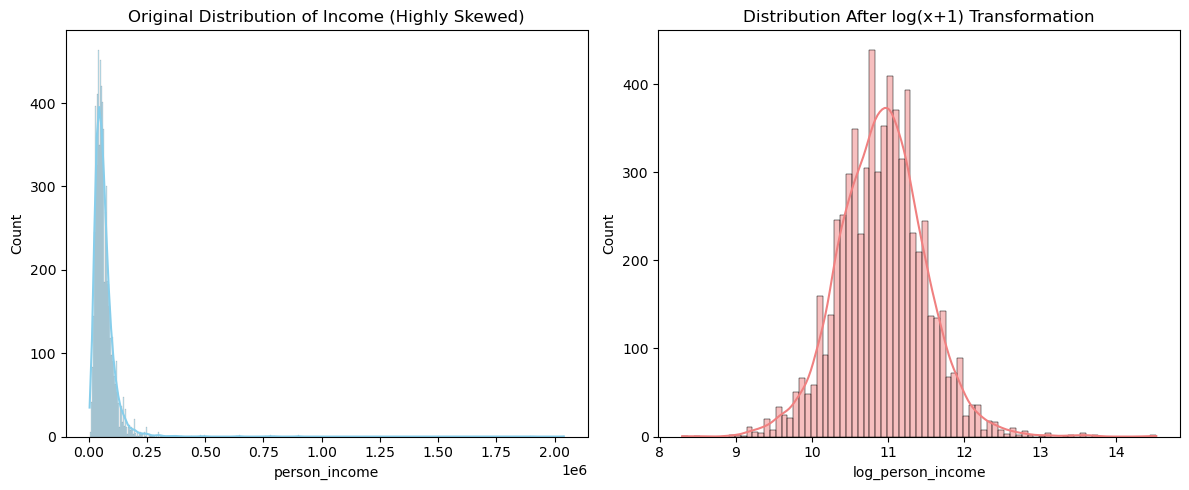

In [152]:
# --- Generate Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original Skewed Feature
sns.histplot(df_raw['person_income'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Original Distribution of Income (Highly Skewed)')
axes[0].set_xlabel('person_income')

# Log-Transformed Feature
sns.histplot(df_raw['log_person_income'], kde=True, ax=axes[1], color='lightcoral')
axes[1].set_title('Distribution After log(x+1) Transformation')
axes[1].set_xlabel('log_person_income')

plt.tight_layout()
plt.savefig('histograms_log_transform_rationale.png')
plt.show()

The income feature was heavily skewed, so a log transformation was applied to make the distribution more symmetrical and suitable for linear models like Logistic Regression.

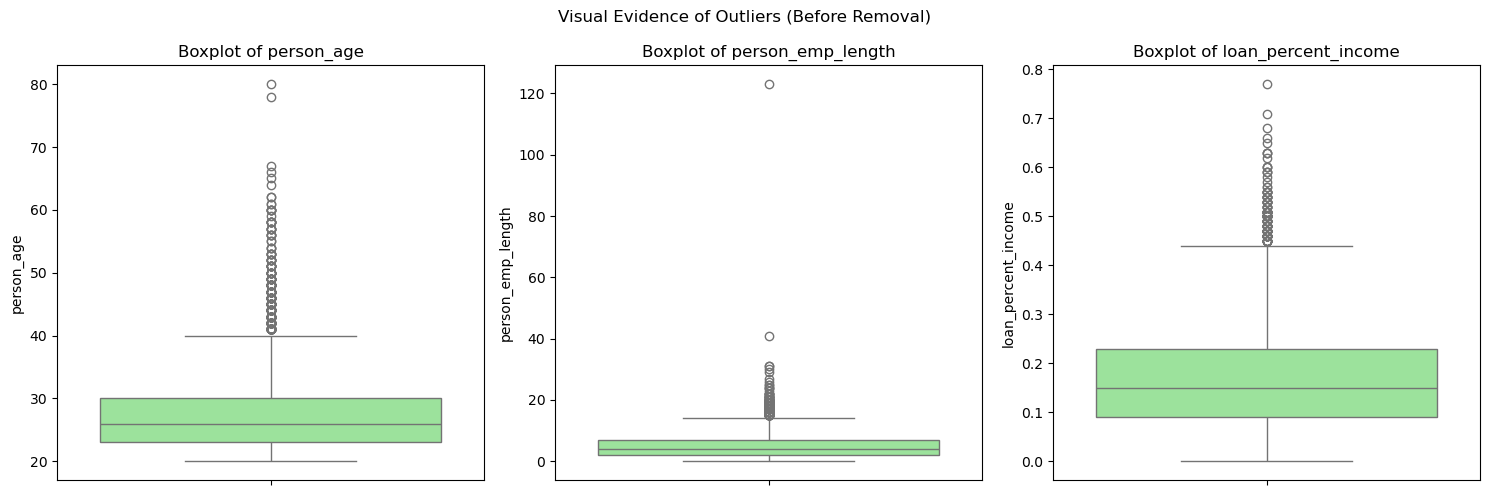

In [153]:
# --- Select columns to show outliers ---
outlier_cols = ['person_age', 'person_emp_length', 'loan_percent_income']

# --- Generate Plot ---
plt.figure(figsize=(15, 5))

for i, col in enumerate(outlier_cols):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=df_raw[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

plt.suptitle('Visual Evidence of Outliers (Before Removal)')
plt.tight_layout()
plt.savefig('boxplots_outlier_rationale.png')
plt.show()

Boxplots showed several extreme outliers in key features like age and employment length. These were removed (using the 3-sigma rule) to prevent them from negatively impacting model training."

In [129]:
# Apply Log Transformation for required columns
log_cols = ['person_income', 'person_age', 'loan_amnt', 'loan_int_rate']
for col in log_cols:
    df[f'log_{col}'] = np.log1p(df[col])
    df = df.drop(columns=[col])

In [130]:
# Define numerical columns for Outlier Removal
numerical_cols = ['person_emp_length', 'loan_percent_income', 'cb_person_cred_hist_length'] + [f'log_{c}' for c in log_cols]

In [131]:
# Outlier Removal (using 3 standard deviations)
initial_rows = len(df)
for col in numerical_cols:
    mean = df[col].mean()
    std = df[col].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
print(f"Data Cleaning: Removed {initial_rows - len(df)} rows as outliers.")

Data Cleaning: Removed 288 rows as outliers.


In [132]:
# One-Hot Encode Categorical Features
categorical_cols = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [133]:
# Separate features (X) and target (y)
X = df_processed.drop(columns=['loan_status'])
y = df_processed['loan_status']

# Correlation Heatmap

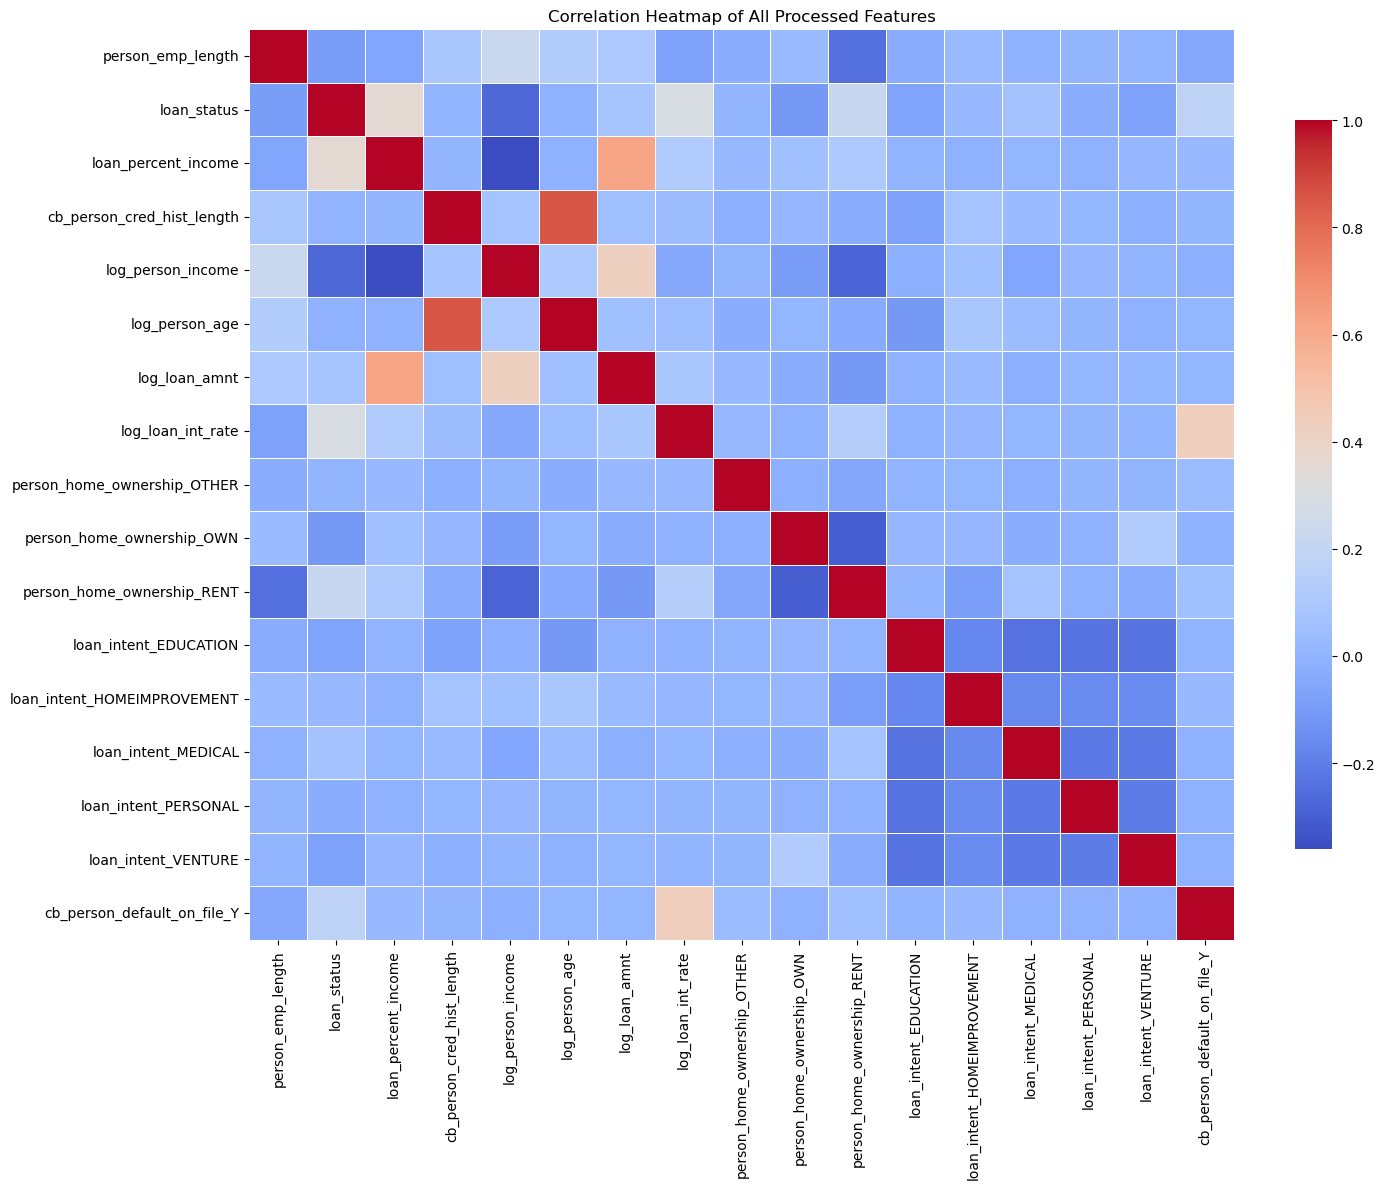

In [156]:
df_corr = df_processed.copy()

# Convert Boolean columns (created during One-Hot Encoding) to integers (1/0)
# This is necessary because the .corr() function needs numbers to calculate correlation.
for col in df_corr.select_dtypes(include=['bool']).columns:
    df_corr[col] = df_corr[col].astype(int)

# Calculate the correlation matrix
corr_matrix = df_corr.corr()

# --- Generate Plot ---
plt.figure(figsize=(15, 12))
sns.heatmap(
    corr_matrix, 
    annot=False, # Set to True if you want numbers, but often too cluttered
    cmap='coolwarm', 
    fmt=".2f",
    linewidths=.5,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of All Processed Features')
plt.tight_layout()
plt.savefig('correlation_heatmap_final_features.png')
plt.show()

1. "The correlation heatmap confirmed no major collinearity issues (no high correlation between independent features)." 
2. "The target correlation row/column indicated that features like 'loan_percent_income' were the strongest predictors of default risk."

## Modeling Pipeline and Variable Setup

In [136]:
# 1. Split X (features) and y (target)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [137]:
# 2. Apply SMOTE only on the training data
sampler = SMOTE(random_state=42)
X_train_smote, y_train_smote = sampler.fit_resample(X_train, y_train)

print(f"Split data: Train={len(X_train)} rows, Test={len(X_test)} rows.")
print('Original Training set shape %s' % Counter(y_train))
print('Resampled Training set shape %s' % Counter(y_train_smote))

Split data: Train=4983 rows, Test=1246 rows.
Original Training set shape Counter({0: 3898, 1: 1085})
Resampled Training set shape Counter({0: 3898, 1: 3898})


In [138]:
# 3. Define the required variables for the submission cell
# The assignment requires the test data to be named 'xtest' and 'ytest'
xtest = X_test
ytest = y_test

In [139]:
# 4. Train the model (Name MUST be 'model' for the submission cell)
model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
model.fit(X_train_smote, y_train_smote)
print("Model trained successfully.")

Model trained successfully.


## Final Evaluation

In [140]:
# Generate predictions on the test data
prediction_labels = model.predict(xtest)

In [141]:
# Calculate the required metrics
f1 = f1_score(ytest, prediction_labels)
conf_matrix = confusion_matrix(ytest, prediction_labels)

In [143]:
# Print the required outputs
print("Final Output:")
print(f"F1: {f1:.4f}")
print("\nConfusion Matrix (ytest vs. prediction_labels):\n")
print(conf_matrix)

Final Output:
F1: 0.5690

Confusion Matrix (ytest vs. prediction_labels):

[[743 232]
 [ 71 200]]


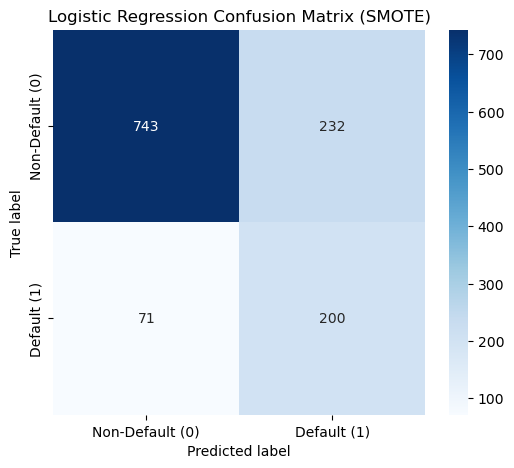

In [144]:
# Visualization of Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Default (0)', 'Default (1)'],
            yticklabels=['Non-Default (0)', 'Default (1)'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Logistic Regression Confusion Matrix (SMOTE)')
plt.show()

### Accuracy Test

Replace the green part with whatever you need to transform the fresh data into the format needed for your model to predict. 

<b>Note:</b> you could test and make sure that things are working OK here by taking part of your dataset, saving it in a separate CSV, and running it through here as a piece of test data. The accuracy results would be useless, but you'd confirm that the model works properly. 

F1: 0.5689900426742532


<Axes: >

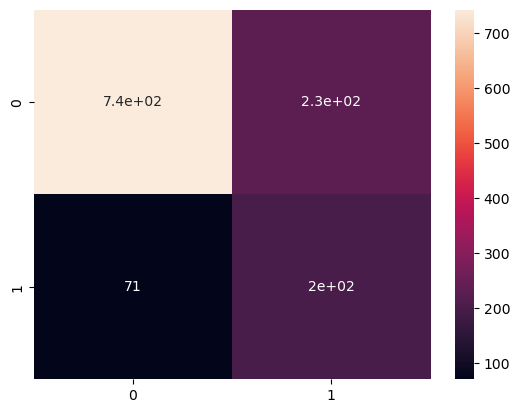

In [145]:
d_test = pd.read_csv("test copy.csv")

######################
# Insert whatever you need to do to prep the data here. 
# It might be nothing if you have a big pipeline. 
# Ensure that at the end your data is in two arrays - xtest and ytest
# Ensure the name of your final model is "model"
# Each should contain the ENTIRE x or y dataset in the test data. 
#
# This part should be reusable - any dataset in this format should just run
# and generate predictions and accuracy stats. 
# Please DO NOT do any train-test splitting here. 
#######################

# This should work once you're done, as is. 
# uncomment the stuff below when ready to run.
print("F1:",f1_score(ytest, prediction_labels))
conf_matrix = confusion_matrix(ytest, prediction_labels)
sns.heatmap(conf_matrix, annot=True)